In [1]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

database = 'qardio'
host = '127.0.0.1'
user = 'root'
password = 'Party100'
url = f'mysql+mysqlconnector://{user}:{password}@{host}/{database}'
engine = sqlalchemy.create_engine(url, echo=True)
conn = engine.connect()

pd.set_option('display.max_columns', 500)

2023-06-22 15:22:41,308 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-06-22 15:22:41,310 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-22 15:22:41,312 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-06-22 15:22:41,313 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-22 15:22:41,315 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-06-22 15:22:41,316 INFO sqlalchemy.engine.Engine [raw sql] {}


In [2]:
# query database
sql = """
SELECT c.date,
	c.monthstart,
	e.*
FROM calendar c
LEFT JOIN emails e ON c.date = e.date_sent
WHERE c.date >= (SELECT MIN(date_sent) FROM emails)
	AND c.date <= (SELECT MAX(date_sent) FROM emails)
ORDER BY c.date;
"""

all_data = pd.read_sql(sql=sql,
                       con=conn,
                       parse_dates=['date'],
                       index_col='date')

2023-06-22 15:22:41,340 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2023-06-22 15:22:41,346 INFO sqlalchemy.engine.Engine [generated in 0.00911s] {'table_schema': 'qardio', 'table_name': '\nSELECT c.date,\n\tc.monthstart,\n\te.*\nFROM calendar c\nLEFT JOIN emails e ON c.date = e.date_sent\nWHERE c.date >= (SELECT MIN(date_sent) FROM emails)\n\tAND c.date <= (SELECT MAX(date_sent) FROM emails)\nORDER BY c.date;\n'}
2023-06-22 15:22:41,364 INFO sqlalchemy.engine.Engine 
SELECT c.date,
	c.monthstart,
	e.*
FROM calendar c
LEFT JOIN emails e ON c.date = e.date_sent
WHERE c.date >= (SELECT MIN(date_sent) FROM emails)
	AND c.date <= (SELECT MAX(date_sent) FROM emails)
ORDER BY c.date;

2023-06-22 15:22:41,378 INFO sqlalchemy.engine.Engine [raw sql] {}


In [7]:
all_data.columns

Index(['monthstart', 'campaign_name', 'date_sent', 'subject_line',
       'subscribers', 'country', 'recipients', 'opens', 'open_rate', 'clicks',
       'click_rate', 'true_click_rate', 'click_per_unique_opens', 'unsubs',
       '%_unsubs', '%_unsubs_openers', 'bounced', 'sessions',
       'sess_per_unique_opens', 'ecr', 'total_trans', 'revenue', 'aov',
       'qardioarm', 'qardiobase_2', 'qardiobase_x', 'qardiotemp', 'qardiospo2',
       'qa_case', 'qa+qbx_bundle', 'qa+qb_bundle', 'qa+spo2', 'qtemp+spo2',
       'ultimate_bundle', 'qardio_core', 'total_quantity'],
      dtype='object')

Review impact of increasing recipients on revenue

<Axes: xlabel='recipients', ylabel='revenue'>

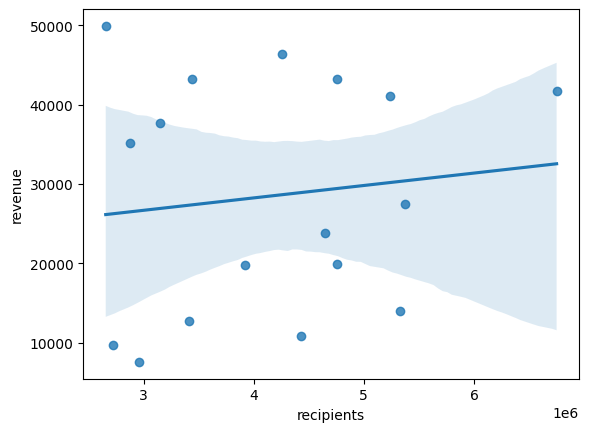

In [4]:
monthly = pd.DataFrame(all_data.groupby('monthstart').aggregate({'recipients': 'sum', 'revenue': 'sum'}))
monthly = monthly.loc[monthly['revenue'] < 80000, :]
sns.regplot(data=monthly, x='recipients', y='revenue')

<Axes: xlabel='recipients', ylabel='%_unsubs'>

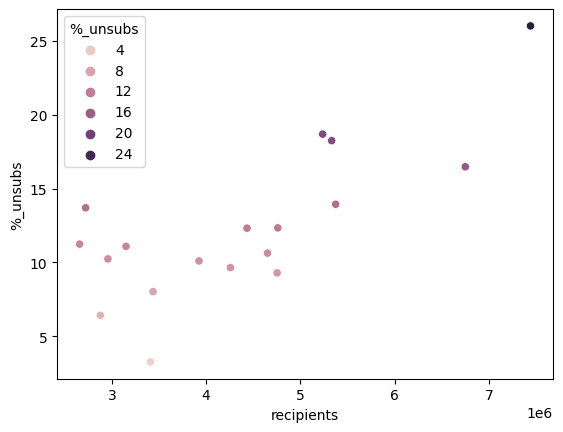

In [13]:
monthly = pd.DataFrame(all_data.groupby('monthstart').aggregate({'recipients': 'sum', '%_unsubs': 'sum'}))
sns.scatterplot(data=monthly, x='recipients', y='%_unsubs', hue='%_unsubs')

Gradient: 4.756236604799368e-06


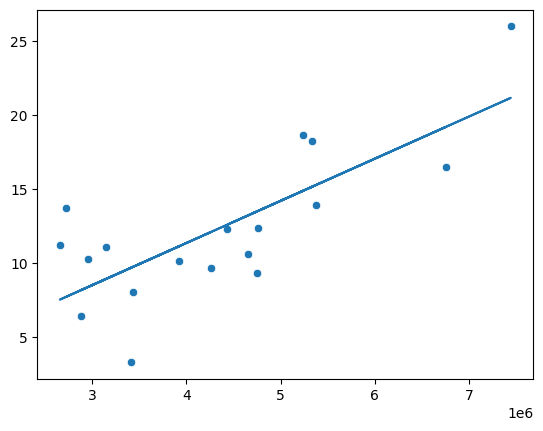

In [50]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = np.array(monthly['recipients'].values)
y = np.array(monthly['%_unsubs'].values)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

reg = LinearRegression()
reg.fit(X=X, y=y)
data = reg.predict(X)

sns.scatterplot(x=X.flatten(), y=y.flatten())
plt.plot(X, data)
print(f'Gradient: {(y.max() - y.min()) / (X.max() - X.min())}')

0.0